# Task: Sobolev training of FFNNs
#### Using neural networks for reduced order modelling of the Euler-Bernoulli beam

---

Lecture: "Physics-augmented machine learning" @ Cyber-Physical Simulation, TU Darmstadt

Lecturer: Prof. Oliver Weeger

Content creators: Jasper O. Schommartz, Dominik K. Klein

Summer term 2024

---

#### In this notebook, you will...

* calibrate a FFNN using Sobolev training.
* learn what Sobolev training is and how it can be implemented in Tensorflow.
* learn how Sobolev training can be applied for mechanical systems.
* learn to identify mechanical systems that are suitable for of Sobolev training.
* learn to reflect on the impact of loss weights and hyperparameters on model performance.

In [1]:
from os.path import join
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

K = tf.keras.backend
K.clear_session()

*Run the following two cells to clone the GitHub repository in your current Google Colab environment*

In [ ]:
!git clone https://github.com/CPShub/LecturePhysicsAwareML.git

In [ ]:
from LecturePhysicsAwareML.FFNN_ROM.src.data import read_data, static, dirac, sine, multisine
import LecturePhysicsAwareML.FFNN_ROM.src.plot as p
import LecturePhysicsAwareML.FFNN_ROM.src.evaluation as e

# Data path
path = join('LecturePhysicsAwareML', 'FFNN_ROM', 'data')

*Run the following cell if you are using Jupyter Notebook locally on your device.*

In [2]:
from src.data import read_data, static, dirac, step, sine, multisin
import src.plot as p
import src.evaluation as e

# Data path
path = 'data'

## 1. Recap of ROM with POD

Proper orthogonal decomposition (POD) is a data-driven method for finding a reduced basis that approximates the behavior of a dynamical system. Based on the snapshot matrix $\mathbb{S} = (\boldsymbol{u}_1,\boldsymbol{u}_1, ...) \in \mathbb{R}^{N\times M}$, which contains time series data of the degrees of freedoms, e.g. displacements, the reduced basis $\boldsymbol{Q} = (\mathbb{u}_1, ..., \mathbb{u}_m) \in \mathbb{R}^{N \times m}$ is found using singular value decomposition (SVD).

After applying POD to the dynamics of the nonlinear Euler-Bernoulli beam, the behavior can be described by the following nonlinear differential equation

$$
\boldsymbol{Q}^T \boldsymbol{M} \boldsymbol{Q}\ddot{\boldsymbol{q}} + \tilde{\boldsymbol{f}}(\boldsymbol{q}) = \boldsymbol{Q}^T \boldsymbol{b}(t),
$$

where the nonlinear function $\tilde{\boldsymbol{f}}(\boldsymbol{q}) = \boldsymbol{Q}^T \boldsymbol{f}(\boldsymbol{Q}\boldsymbol{q})$ describes the internal forces in terms of the reduces degrees of freedom $\boldsymbol{q}$. The simulation of the equation above requires a time integration scheme. For this lecture the Newmark method was implemented in the `nlebb_dynamic_proj.m` MATLAB script. It makes use of the linearization of $\tilde{\boldsymbol{f}}(\boldsymbol{q})$, which is given in terms of the reduced stiffnes matrix $\tilde{\boldsymbol{K}} = \boldsymbol{Q}^T \boldsymbol{K} \boldsymbol{Q}$. $\tilde{\boldsymbol{K}}(\boldsymbol{q})$ is related to $\tilde{\boldsymbol{f}}(\boldsymbol{q})$ via the derivative as

$$
\tilde{\boldsymbol{K}}(\boldsymbol{q}) = \frac{\partial \tilde{\boldsymbol{f}}(\boldsymbol{q})}{\partial \boldsymbol{q}}
$$

## 2. Task summary

In this task we aim to train a FFNN-based model to approximate the nonlinear functions $\tilde{\boldsymbol{f}}(\boldsymbol{q})$ and $\tilde{\boldsymbol{K}(\boldsymbol{q})}$ replacing the numerically expensive evaluation of $\boldsymbol{Q}^T \boldsymbol{f}(\boldsymbol{Q}\boldsymbol{q})$ during the beam simulation. Since $\tilde{\boldsymbol{f}}(\boldsymbol{q})$ and $\tilde{\boldsymbol{K}(\boldsymbol{q})}$ are related via the derivative, *Sobolev training* shall be used for the calibration.

The task involves four step, where one is covered by this notebook:

1. Determination of the reduced basis using POD and SVD (`nlebb_dynamic_svd.m`)
2. Generation of training and test data sets for $\boldsymbol{q}$, $\tilde{\boldsymbol{f}}$, and $\tilde{\boldsymbol{K}}$ using the reduced basis (`nlebb_dynamic_proj.m`)
3. Training and evaluation of a FFNN-based surrogate model (this Jupyter Notebook)
4. Application of the FFNN in the beam simulation (`nlebb_dynamic_proj.m`)

## 3. FFNN-based model

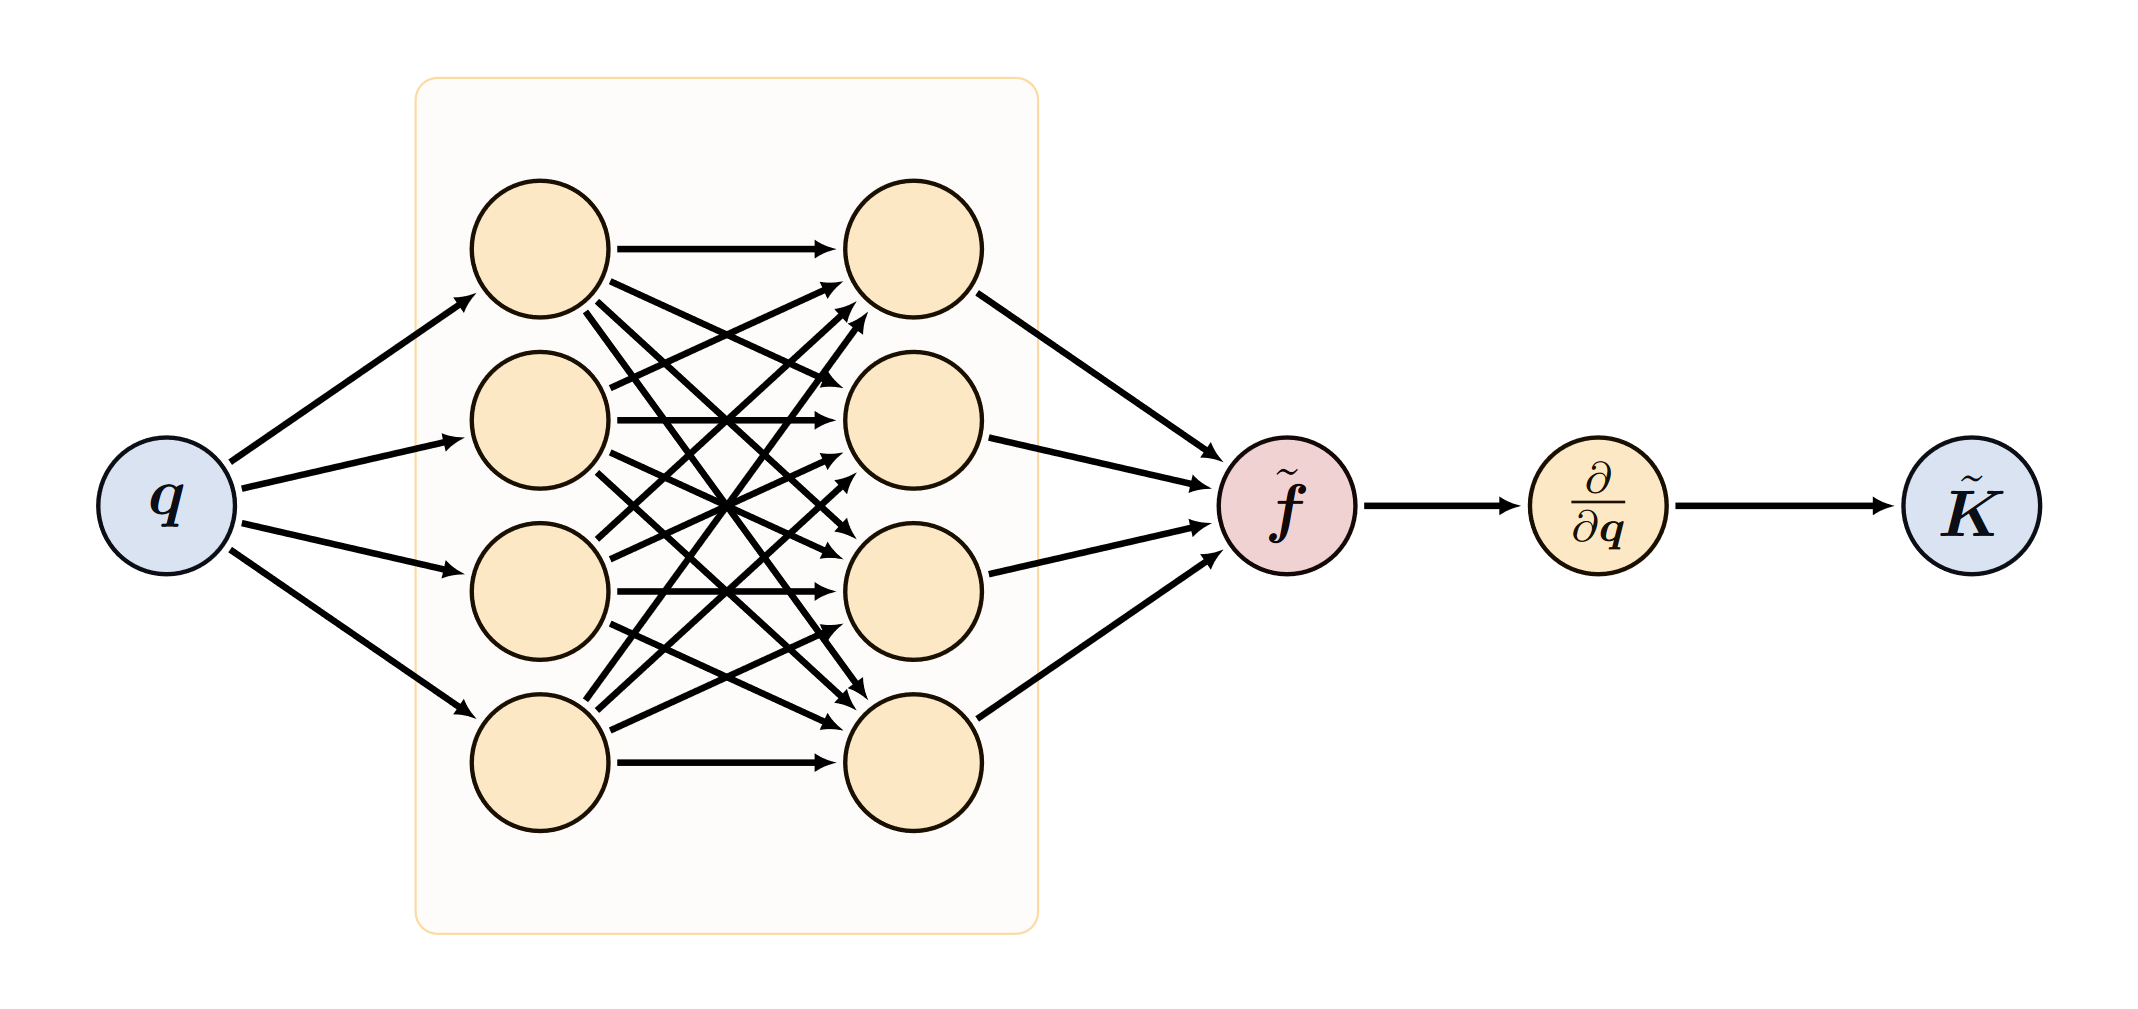

The model consists of of two custom layers. `MLP` represents the FFNN and `Gradient` computes the gradients of the FFNN with respect to its inputs. The gradients are computed using automatic differentiation with the `tf.GradientTape()` module provided by Tensorflow.

In [3]:
class MLP(layers.Layer):
    ''' A feed-forward neural network '''
    def __init__(self, units, activation):
        super().__init__()
        self.ls = []
        for (u, a) in zip(units, activation):
            self.ls += [layers.Dense(u, a)]

    def call(self, x):    
        for l in self.ls:
            x = l(x)
        return x
    
class Gradient(layers.Layer):
    ''' Computes the gradient of another layer and returns
    it together with the function value '''
    def __init__(self, l):
        super().__init__()
        self.l = l # layer of which the gradient shall be computed
        self.flatten = layers.Flatten()

    def call(self, x):
        with tf.GradientTape() as g:
            g.watch(x)
            y = self.l(x)
        dy = g.batch_jacobian(y, x)
        return y, self.flatten(dy)

To create the model, the `build()` function is called. It connects the input values to the output values and compiles the model with the desired optimizer and loss function. By setting the `loss_weights` property, the importance of every output can be adjusted for better training. In this case the first value value defines the weight of the function values $\tilde{\boldsymbol{f}}(\boldsymbol{q})$, while the second value defines the weights for the stiffness matrix $\frac{\partial \tilde{\boldsymbol{f}}(\boldsymbol{q})}{\partial \boldsymbol{q}}$.

In [4]:
def build(qm, loss_weights=[1, 1], *args, **kwargs):
    ''' Builds an evaluation model that returns the nodal displacements '''
    # define input shape
    x = tf.keras.Input(shape=(qm,))
    # define which (custom) layers the model uses
    mlp = MLP(*args, **kwargs)
    grad = Gradient(mlp)
    y, dy = grad(x)
    # connect input and output
    model = tf.keras.Model(inputs = [x], outputs = [y, dy])
    # define optimizer
    model.compile('adam', 'mse', loss_weights=loss_weights)
    return model

## 4. Data generation and Preprocessing

Data generation is contucted a-priori via execution of the `nlebb_dynamic_svd.m`and `nlebb_dynamic_proj.m` scripts. The following types of excitations of the cantilever beam were used for data generation:

* Quasi-static: $Q(t) = A/5 \cdot t$
* Dirac: $Q(t) = A\ \text{if}\ 2.5 < t < 2.51$
* Step: $Q(t) = A\ \text{if}\ t > 2.5$
* Sine: $Q(t) = A \sin(2 \pi f t)$
* Multisine with phase shift: $Q_i(t) = \sum_{k=1}^{n} y_{i, k}(t)\quad$ with $\quad y_{i, k}(t) = A_k \sin(2 \pi f_k t + \varphi_k + \phi_i)\quad$ and $\quad \varphi_k = \frac{-k(k-1)}{n}\pi\quad$ and $\quad \phi_i = \frac{2 \pi (i -1)}{n_{ph}}$

**Training cases**:

* Multisine with $A = 2 N$, $n = 100$, $f_0 = 0.085 Hz$, $n_{ph} = 3$, $i = 1, ..., 3$ and a total simulation time of $t_{max} = 5s$

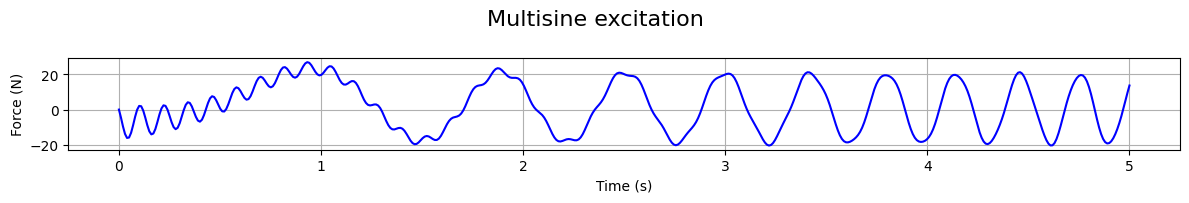

In [5]:
t = np.linspace(0, 5, 500)
multisin(2, 0.085, 100, 0, 3, t)

**Test cases**:

* Quasi-static with $A = -10$
* Dirac with $A = -10$
* Step with $A = -10$
* Sine with $A = 1.5 N$ and $f = 6 Hz$
* Multisine with $A = 1 N$, $n = 78$, $f_0 = 0.103 Hz$, $n_{ph} = 1$, $i = 1$

All training and test cases were simulated for a total time of $t_{max} = 5s$.

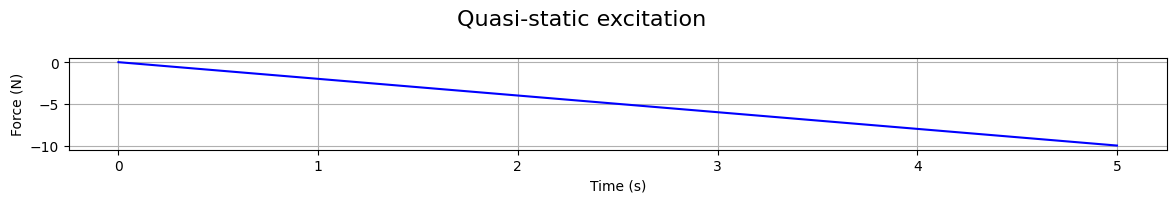

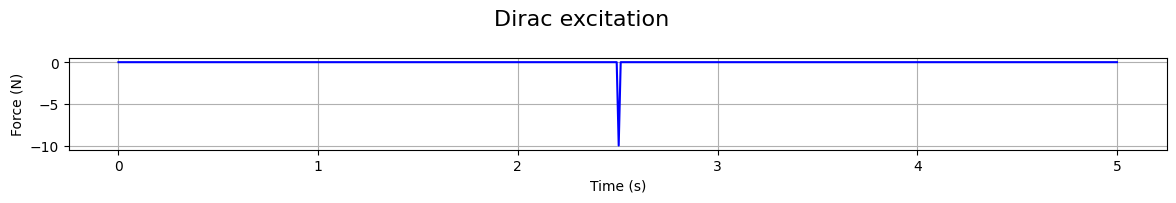

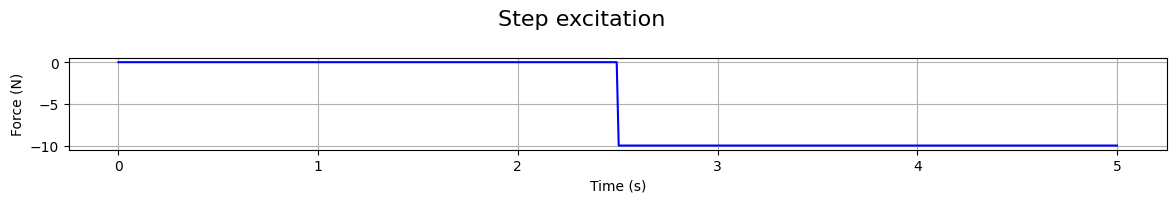

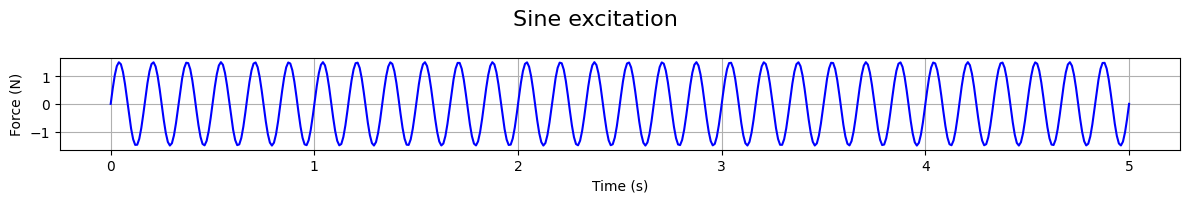

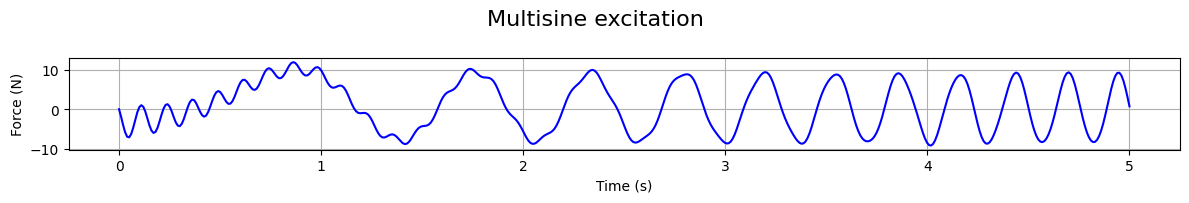

In [6]:
static(-10, t)
dirac(-10, 2.5, t)
step(-10, 2.5, t)
sine(1.5, 6, t)
multisin(1, 0.103, 78, 0, 1, t)

As mentioned, the excitations presented above were used to generate data for the internal reduced forces and stiffnesses $\tilde{\boldsymbol{f}}$ and $\tilde{\boldsymbol{K}}$. This data is not loaded as training data from the `Tasks/FFNN/data/` directory.

In [7]:
# Select training directory and files
dir_name = 'multisin_train'

fnames_q = ['q0all_1.txt', 'q0all_2.txt', 'q0all_3.txt']
fnames_Qf = ['Qfall_1.txt', 'Qfall_2.txt', 'Qfall_3.txt']
fnames_QKQ = ['QKQall_1.txt', 'QKQall_2.txt', 'QKQall_3.txt']

# Read data from txt files
q, Qf, QKQ = read_data(join(path, dir_name), fnames_q, fnames_Qf, fnames_QKQ)
m = q.shape[0]
n = q.shape[1]

Secondly, the internal forces and stiffnesses are visialized.

**Task**: Take a look at the plotted data and try to answer the following questions:

* Which internal forces correlate most with the excitation? What does this tell you about their importance for the model?
* Why don't we normalize the data despite the discrepancy in the orders of magnitude?
* What other solutions are there for fitting data of different magnitudes?

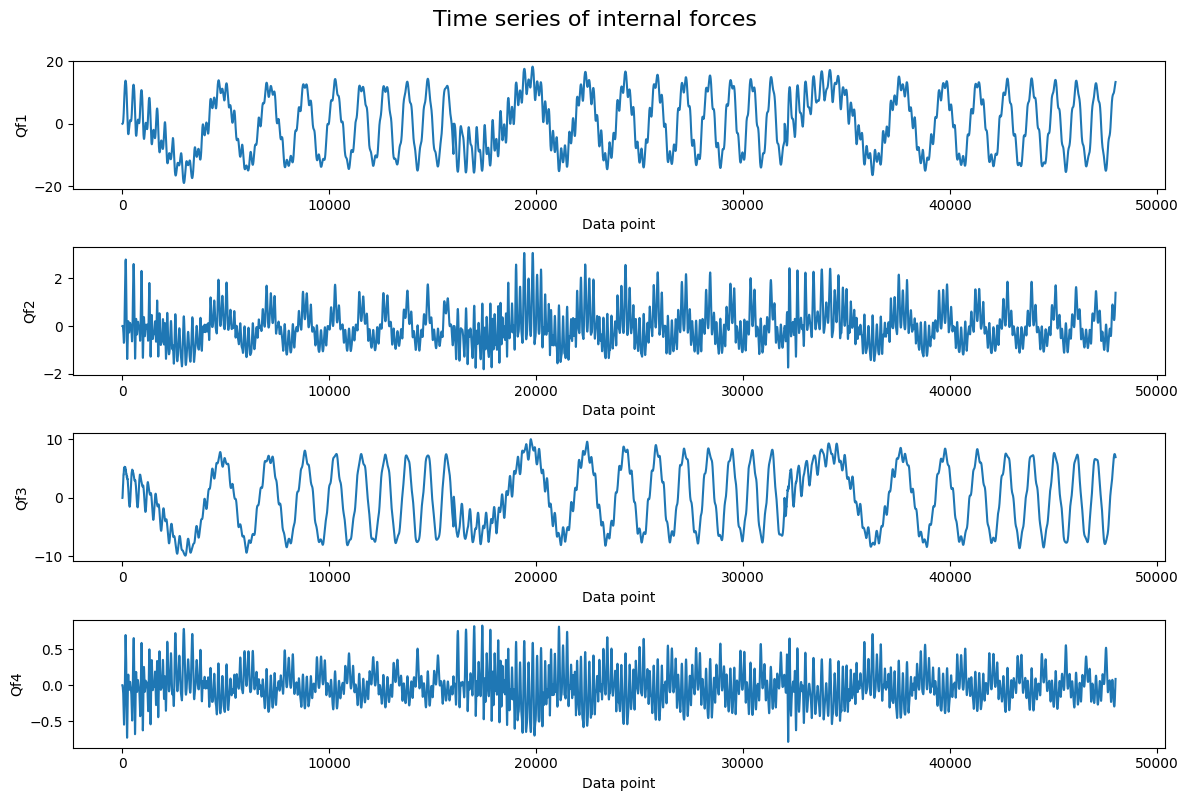

In [8]:
p.plot_forces(Qf)

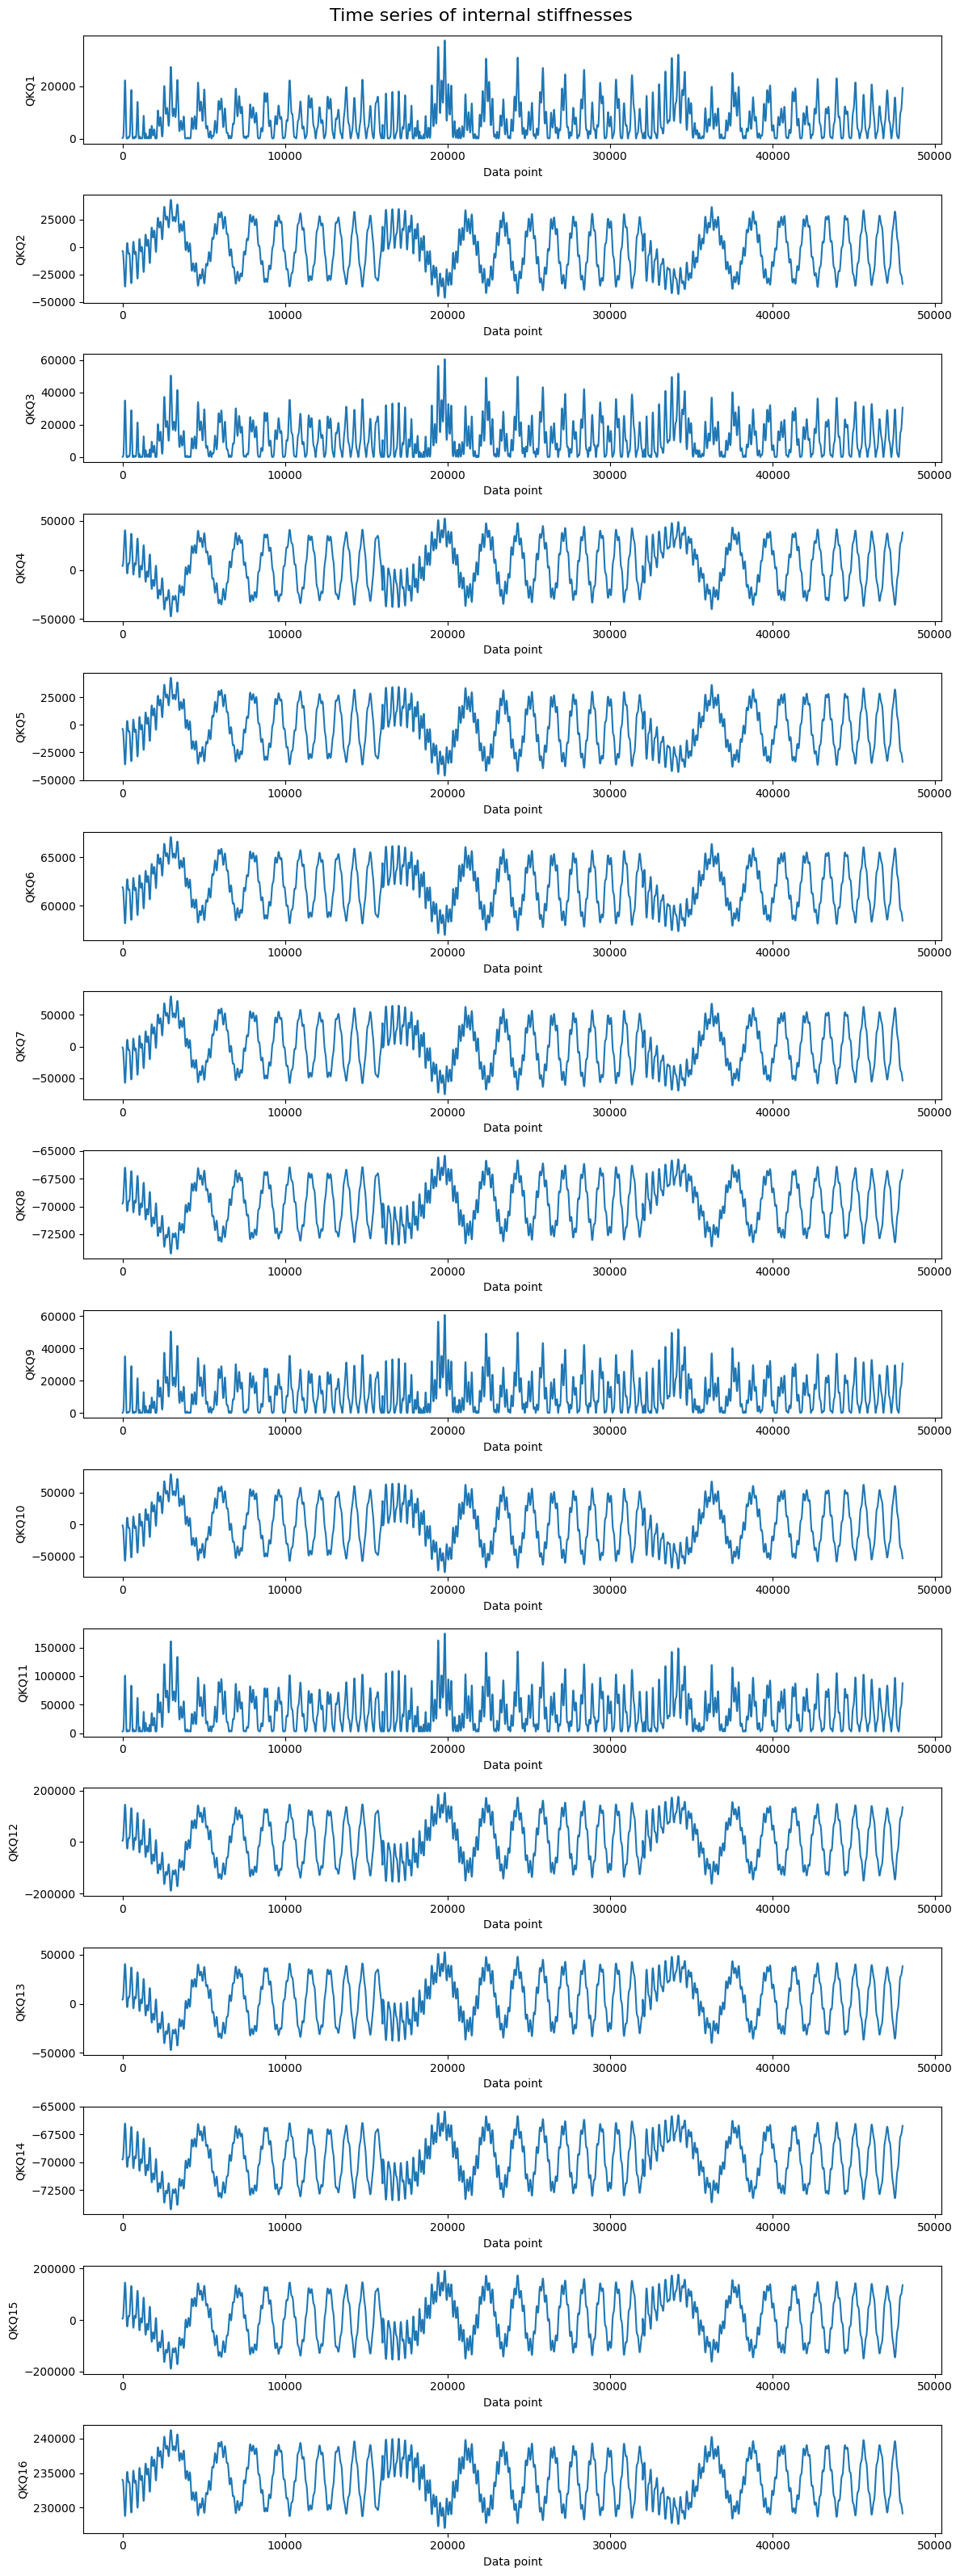

In [9]:
p.plot_stiffnesses(QKQ)

## 5. Building and calibrating the model

The `build()` function is called with the desired `loss_weights`, `units`, i.e., node number, `activation` and `non_neg` constraints.

**Task**: Make changes to the number of nodes as well as the loss weights and investigate the impact on model performance.

In [10]:
model = build(
    qm = n,
    loss_weights=[1, 5e-7], # [1, 5e-7],
    units=[16, 16, 16, 16, n],
    activation=['softplus', 'softplus', 'softplus', 'softplus', 'linear'],
)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 gradient (Gradient)         ((None, 4),               964       
                              (None, 16))                        
                                                                 
Total params: 964 (3.77 KB)
Trainable params: 964 (3.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Next, the model is fitted to the training data after defining the number of training epochs, i.e, `NEPOCHS`, and the learning rate for the ADAM optimizer.

**Task:** Train the model in increments of 500 epochs and observe how the prediction quality on test and training data changes.

Epoch 1/10


1501/1501 - 2s - loss: 2849.3562 - gradient_loss: 15.4286 - gradient_1_loss: 5667856896.0000 - 2s/epoch - 1ms/step
Epoch 2/10
1501/1501 - 1s - loss: 2494.8369 - gradient_loss: 143.6117 - gradient_1_loss: 4702454272.0000 - 992ms/epoch - 661us/step
Epoch 3/10
1501/1501 - 1s - loss: 1401.8763 - gradient_loss: 270.8141 - gradient_1_loss: 2262127104.0000 - 982ms/epoch - 654us/step
Epoch 4/10
1501/1501 - 1s - loss: 1190.2589 - gradient_loss: 309.5717 - gradient_1_loss: 1761373312.0000 - 1s/epoch - 677us/step
Epoch 5/10
1501/1501 - 1s - loss: 1186.7688 - gradient_loss: 324.2888 - gradient_1_loss: 1724957056.0000 - 1s/epoch - 674us/step
Epoch 6/10
1501/1501 - 1s - loss: 1154.8866 - gradient_loss: 308.7107 - gradient_1_loss: 1692350208.0000 - 1s/epoch - 684us/step
Epoch 7/10
1501/1501 - 1s - loss: 1152.8352 - gradient_loss: 310.1264 - gradient_1_loss: 1685416448.0000 - 1s/epoch - 703us/step
Epoch 8/10
1501/1501 - 1s - loss: 1129.0659 - gradient_loss: 299.6495 - gradient_1_loss: 165

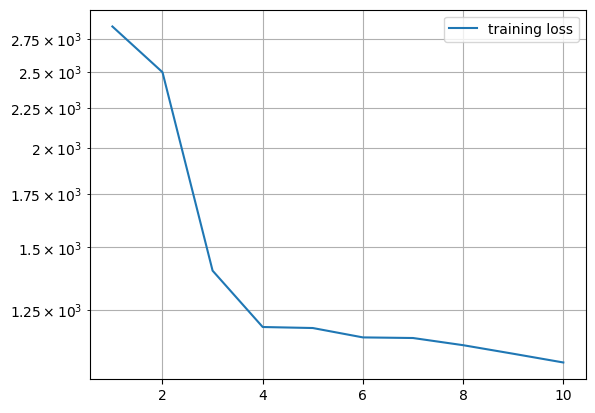

In [11]:
NEPOCHS = 10000
model.optimizer.learning_rate.assign(0.005)
h = model.fit([q], [Qf, QKQ],
              epochs=NEPOCHS,
              verbose=2,
              batch_size=32)

plt.semilogy(np.linspace(1, NEPOCHS, NEPOCHS), h.history['loss'], label='training loss')
plt.grid(which='both')
plt.legend()
plt.show()

The model is saved for later use and the weights are saved in a txt file for use in the beam simulation.

In [11]:
# Save model
model.save_weights('weights_01.h5')

# Save weights to list and txt-file
with open('weights_01.txt', 'w') as f:
    for weights in model.get_weights():
        weights = weights.reshape(-1)
        f.write(' '.join(str(val) for val in weights) + '\n')

In [12]:
# Load weights to skip the training
model.load_weights('weights_01.h5')

## 6. Evaluation

To evaluate the performance of the trained model, it must be tested on unseen data.

### 6.1 Evaluation on training data

However, in the first step we reevaluate the model on the training data to check that no underfitting has occured and that the model is theoretically able to interpolate the data.

In [12]:
# Get model predictions
Qf_pred, QKQ_pred = model(q)

# Evaluate
df_Qf_pred, df_QKQ_pred = e.evaluate(Qf, Qf_pred, QKQ, QKQ_pred)
df_Qf_pred

Qf1         Qf2         Qf3           Qf4
MSE  15.842120  106.255465  218.014262   1114.061565
R2    0.810101 -179.398651   -6.655747 -18906.370043

In [13]:
df_QKQ_pred

QKQ1          QKQ2          QKQ3          QKQ4          QKQ5  \
MSE  9.292814e+07  4.313449e+08  2.387173e+08  2.920707e+07  4.338652e+08   
R2  -1.208093e+00 -1.024738e-02 -1.098212e+00  9.463233e-01 -1.615018e-02   

             QKQ6          QKQ7          QKQ8          QKQ9         QKQ10  \
MSE  3.778072e+09  1.230630e+09  8.328673e+07  2.575804e+08  1.246316e+09   
R2  -6.841901e+02  4.481496e-02 -1.875493e+01 -1.264011e+00  3.263984e-02   

            QKQ11         QKQ12         QKQ13         QKQ14         QKQ15  \
MSE  2.317083e+09  4.645497e+08  5.460493e+08  4.637836e+09  7.375939e+09   
R2  -1.429754e+00  9.406065e-01 -3.529137e-03 -1.099057e+03  5.697379e-02   

            QKQ16  
MSE  8.969781e+08  
R2  -8.142866e+01

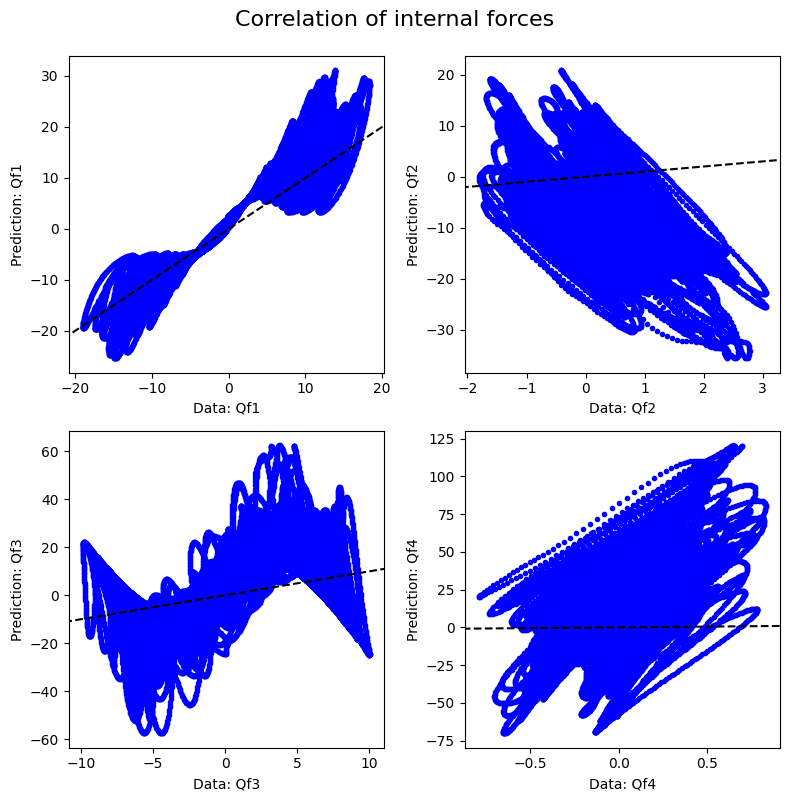

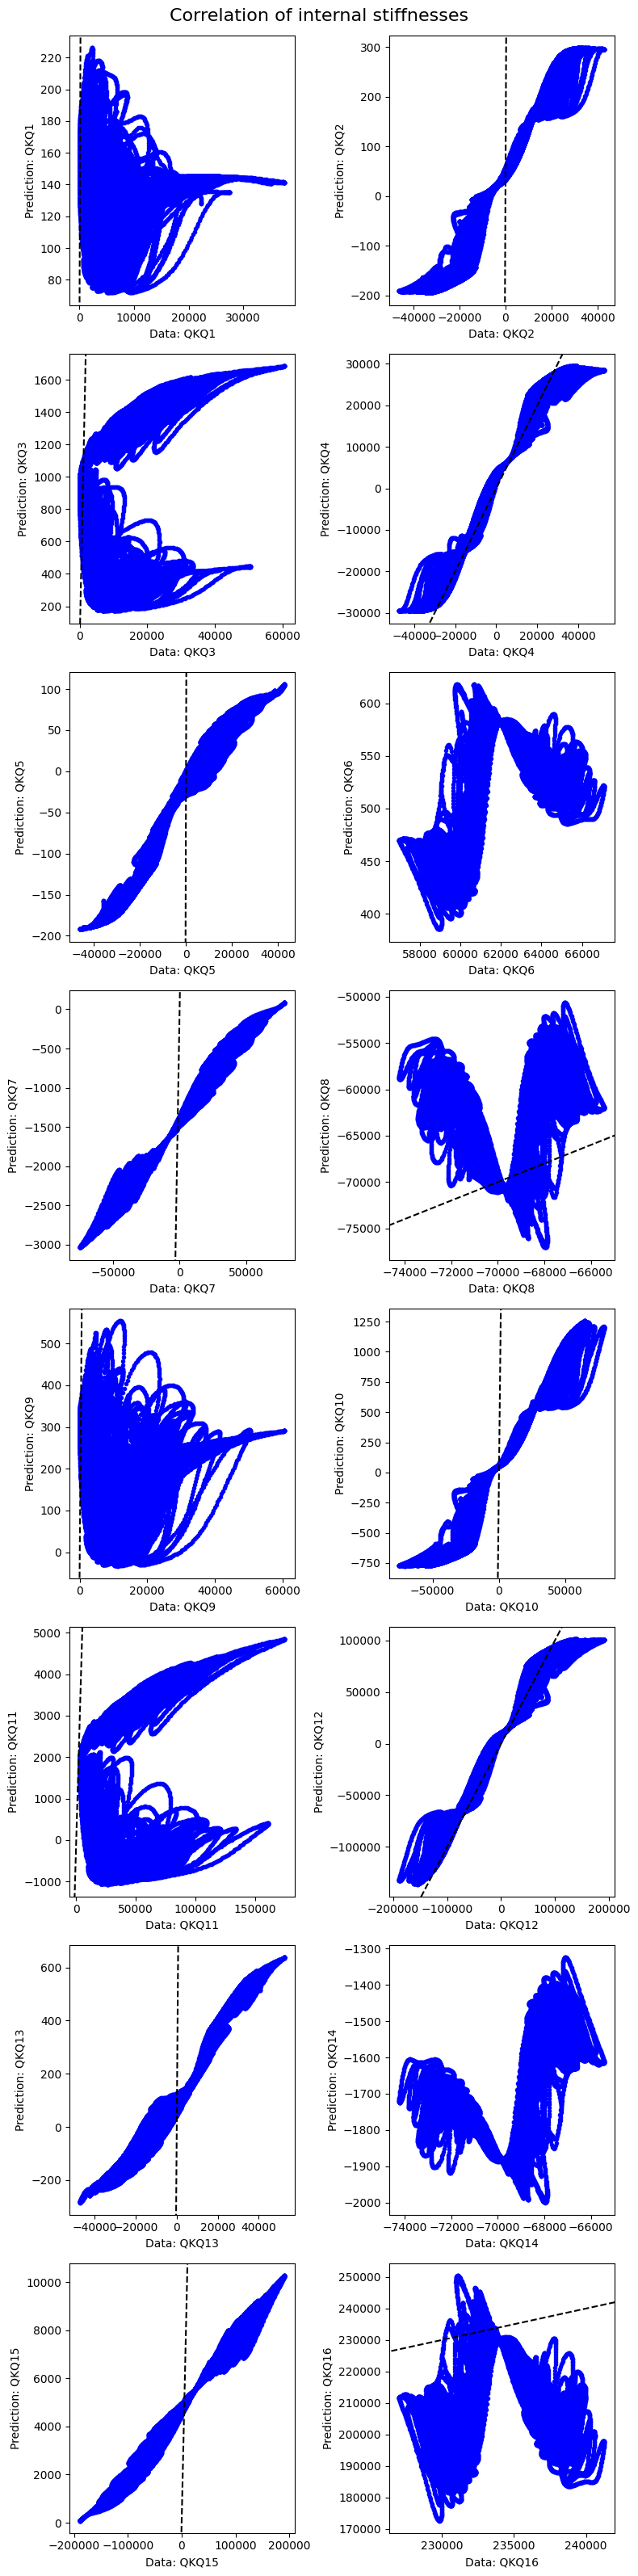

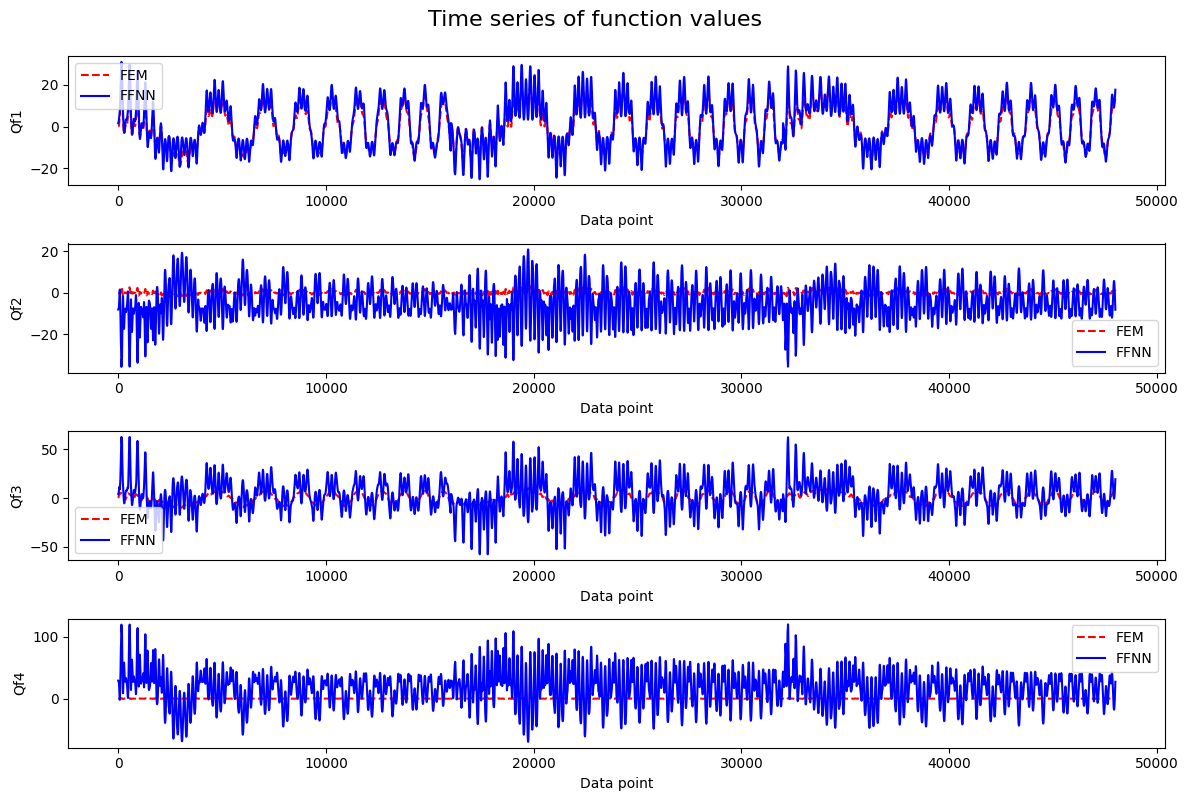

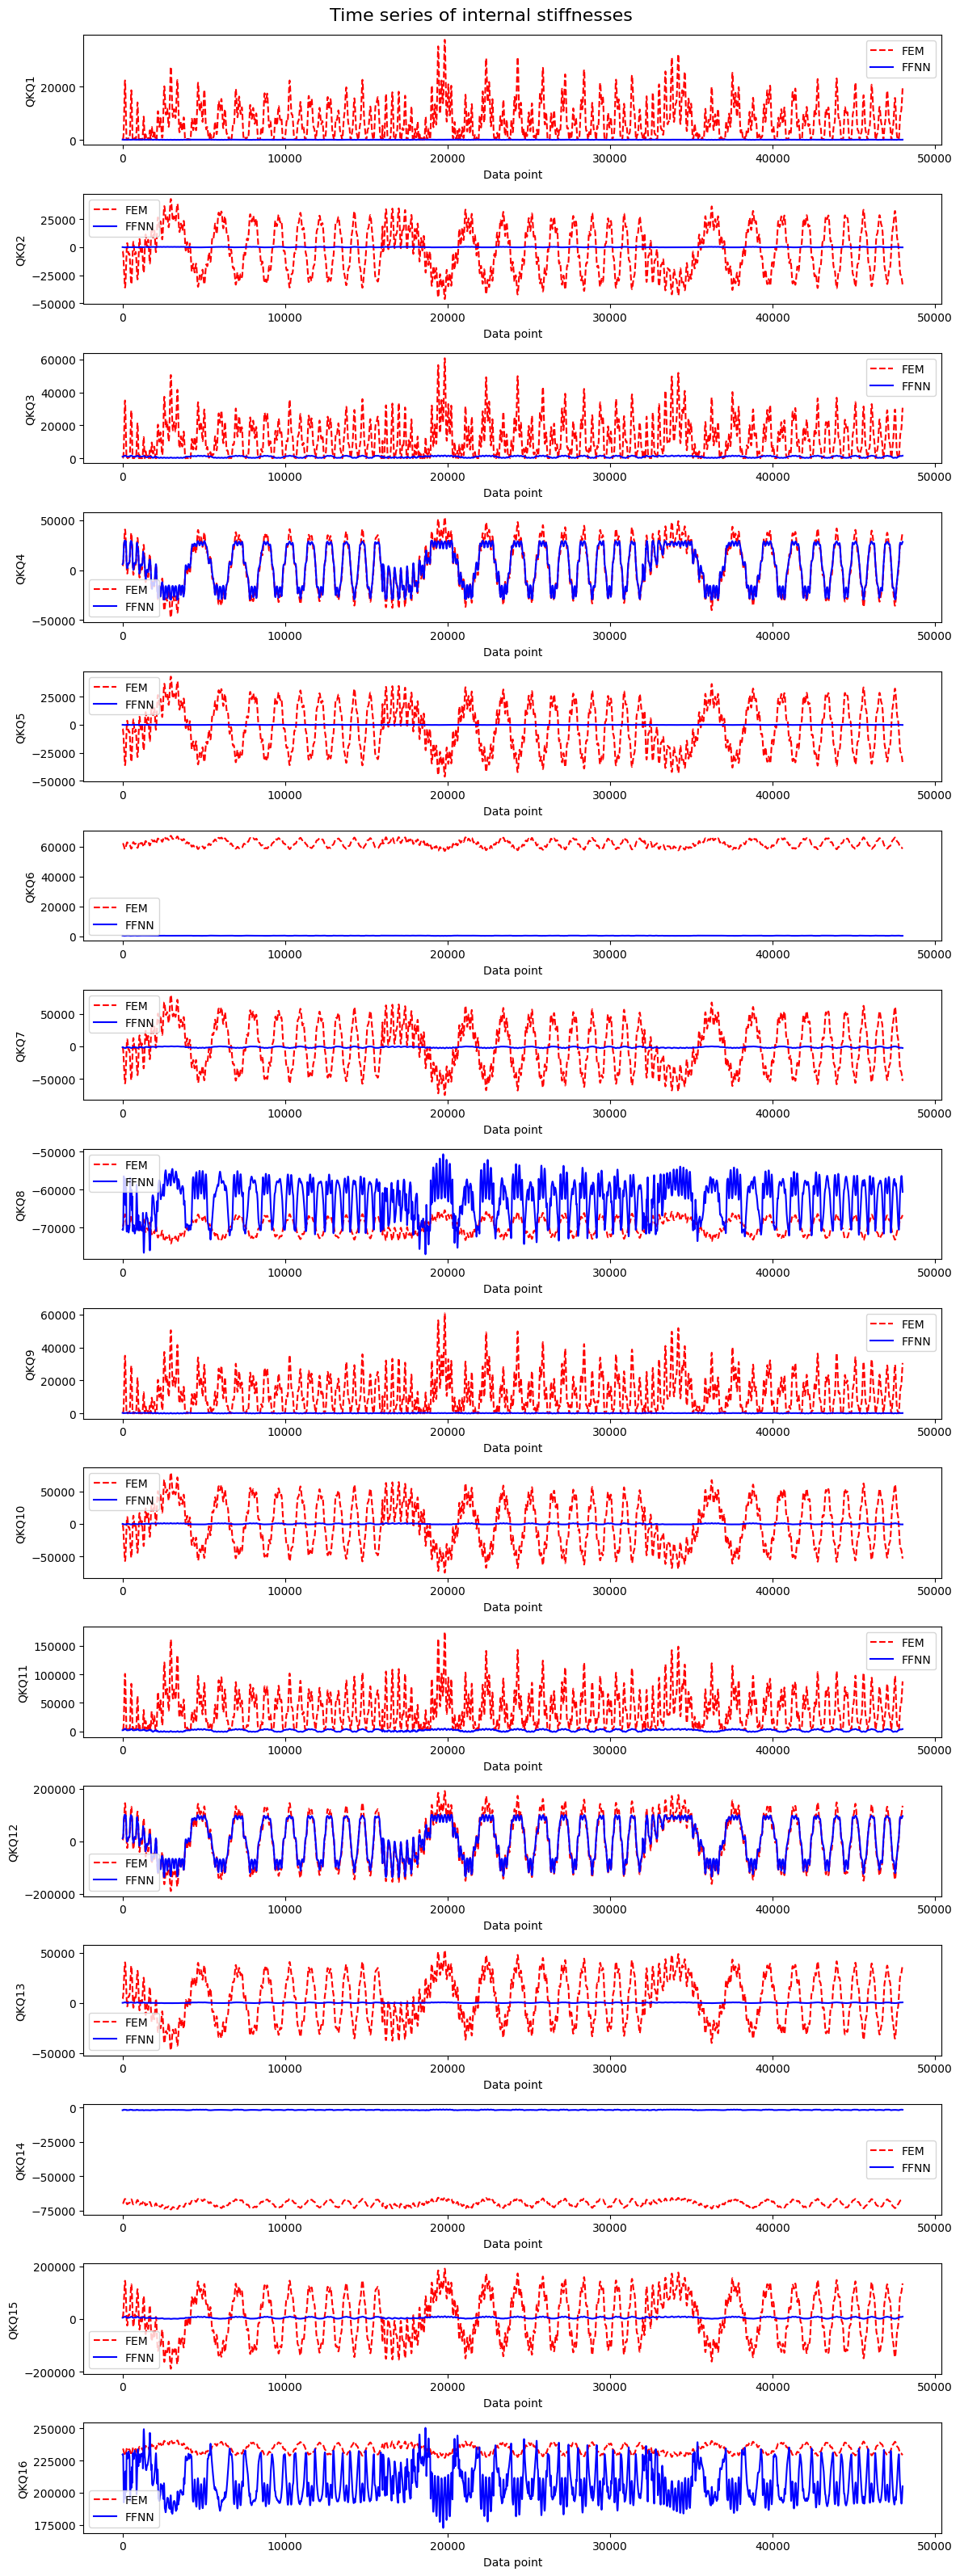

In [14]:
p.plot_predictions(q, Qf, Qf_pred, QKQ, QKQ_pred)

### 6.2 Evaluation on testing data

Finally, the model is evaluated on the testing data.

In [15]:
# Select testing directory and files
dir_name = 'static_test' # Options: 'static_test', 'dirac_test', 'step_test', 'sin_test', 'multisin_test' 
fnames_q = ['q0all.txt']
fnames_Qf = ['Qfall.txt']
fnames_QKQ = ['QKQall.txt']

# Read files
q_test, Qf_test, QKQ_test = read_data(join(path, dir_name), fnames_q, fnames_Qf, fnames_QKQ)

# Get model predictions
Qf_pred_test, QKQ_pred_test = model(q_test)

# Evaluate
df_Qf_test, df_QKQ_test = e.evaluate(Qf_test, Qf_pred_test, QKQ_test, QKQ_pred_test)

The mean squares errors and autocorrelations between the predicted and actual function values are

In [16]:
df_Qf_test

Qf1          Qf2         Qf3           Qf4
MSE  13.537259    45.060918  137.223985  6.207118e+02
R2   -3.219920 -4103.167756 -112.957033 -1.194179e+06

The mean squares errors and autocorrelations between the predicted and actual derivatives are 

In [17]:
df_QKQ_test

QKQ1          QKQ2          QKQ3          QKQ4          QKQ5  \
MSE  6.228855e+06  1.266799e+08  7.396735e+06  5.510205e+06  1.263603e+08   
R2  -2.117931e+00 -7.033598e+00 -6.086385e-01  7.306643e-01 -7.013331e+00   

             QKQ6          QKQ7          QKQ8          QKQ9         QKQ10  \
MSE  3.670058e+09  1.840224e+08  1.679242e+07  1.154041e+07  2.218165e+08   
R2  -1.779294e+04 -2.845900e+00 -1.044670e+02 -1.509802e+00 -3.635761e+00   

            QKQ11         QKQ12         QKQ13         QKQ14         QKQ15  \
MSE  8.385902e+07  7.846298e+07  1.588693e+08  4.525854e+09  1.124676e+09   
R2  -1.675944e+00  7.331547e-01 -6.765442e+00 -2.842422e+04 -2.824920e+00   

            QKQ16  
MSE  2.323218e+08  
R2  -5.644855e+02

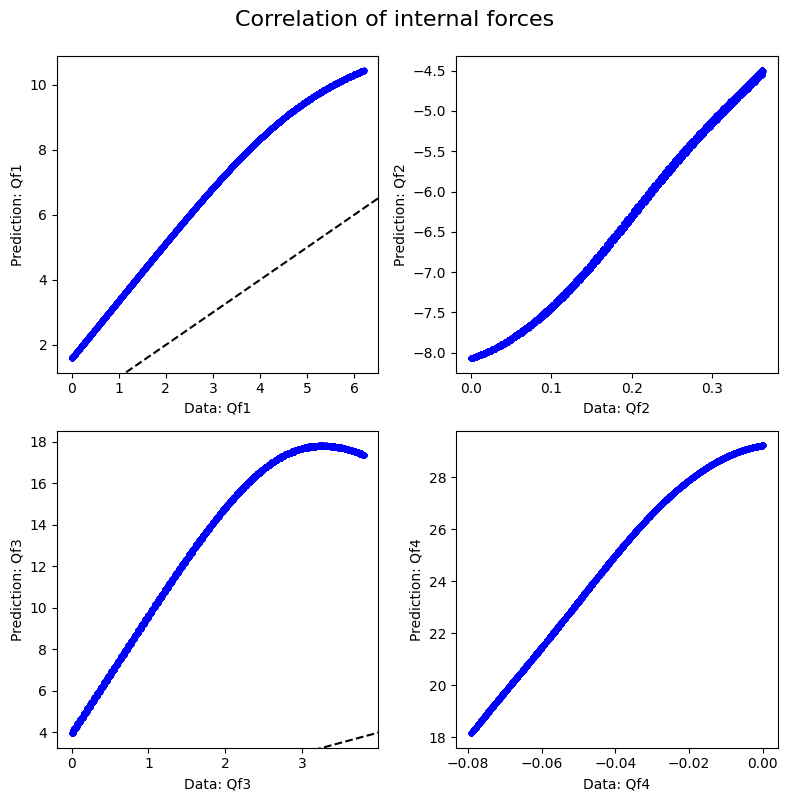

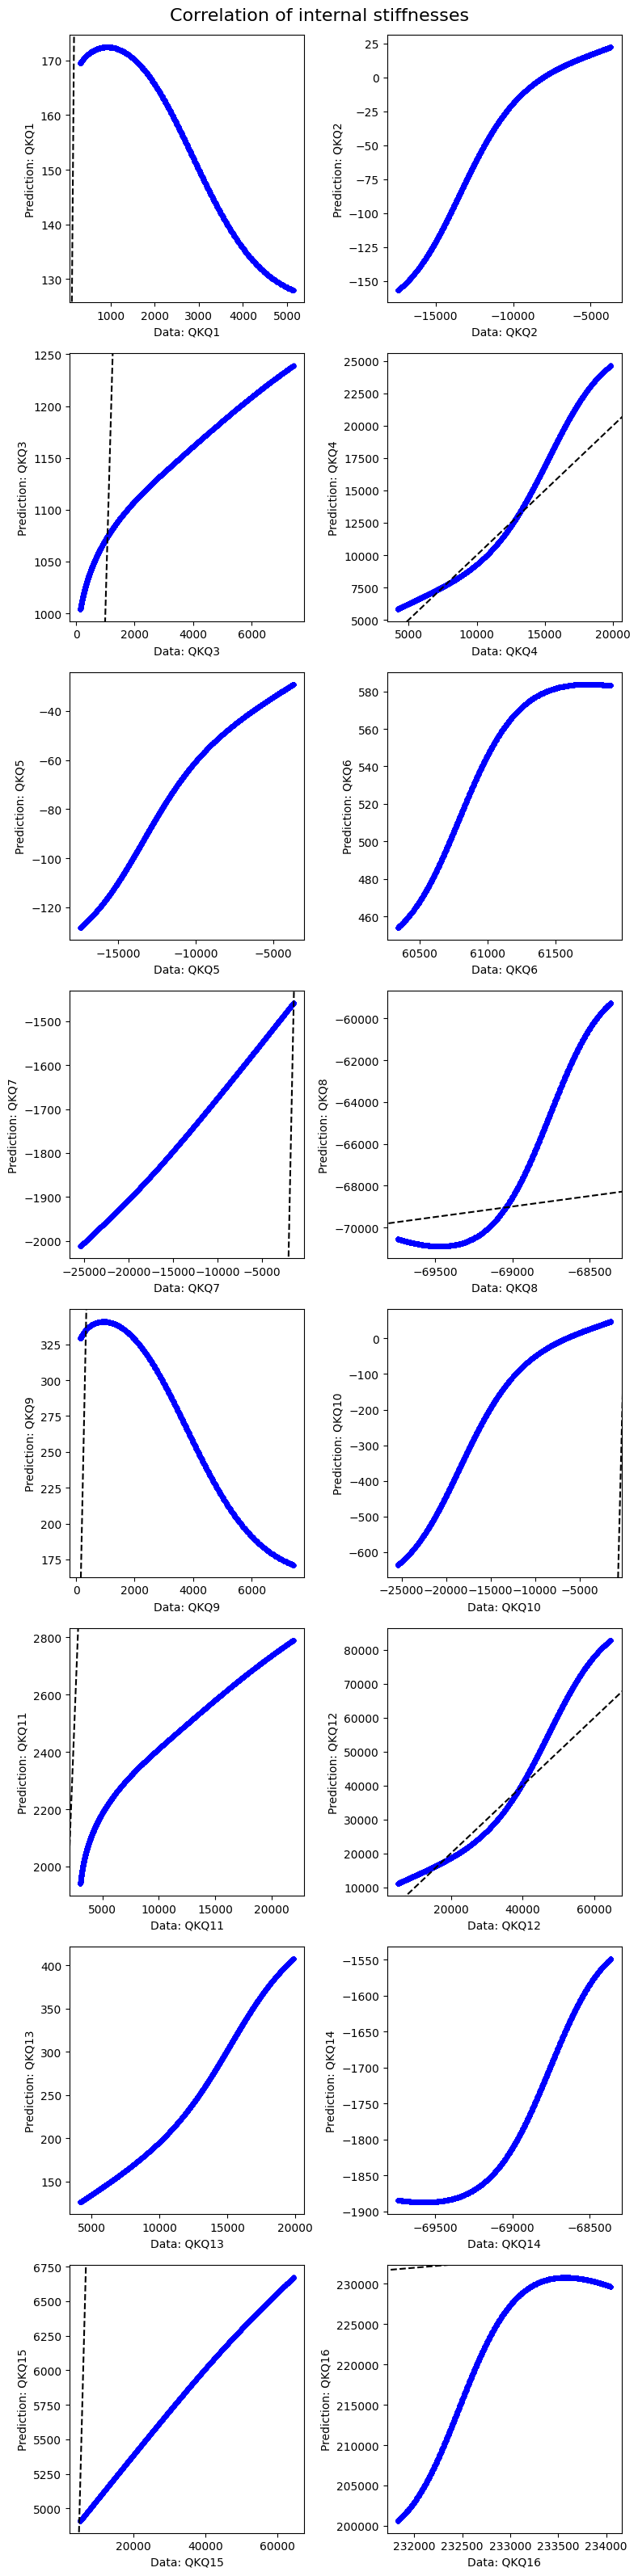

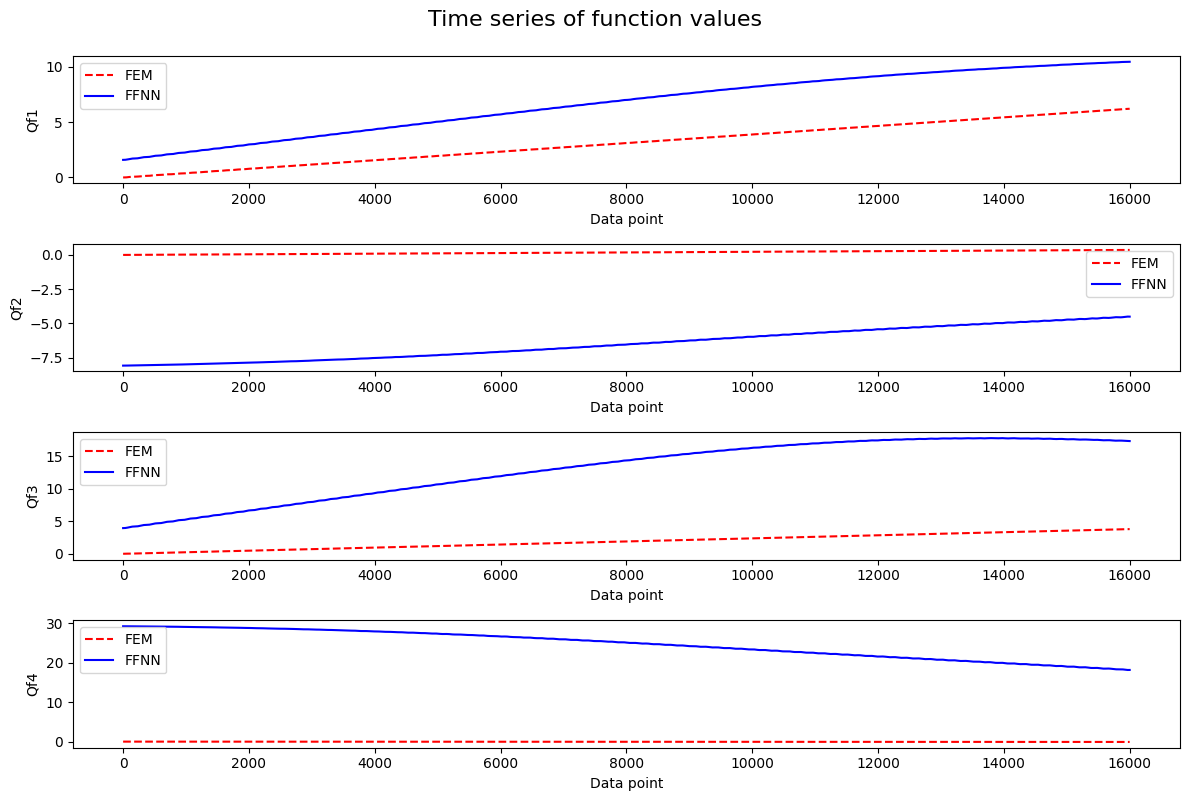

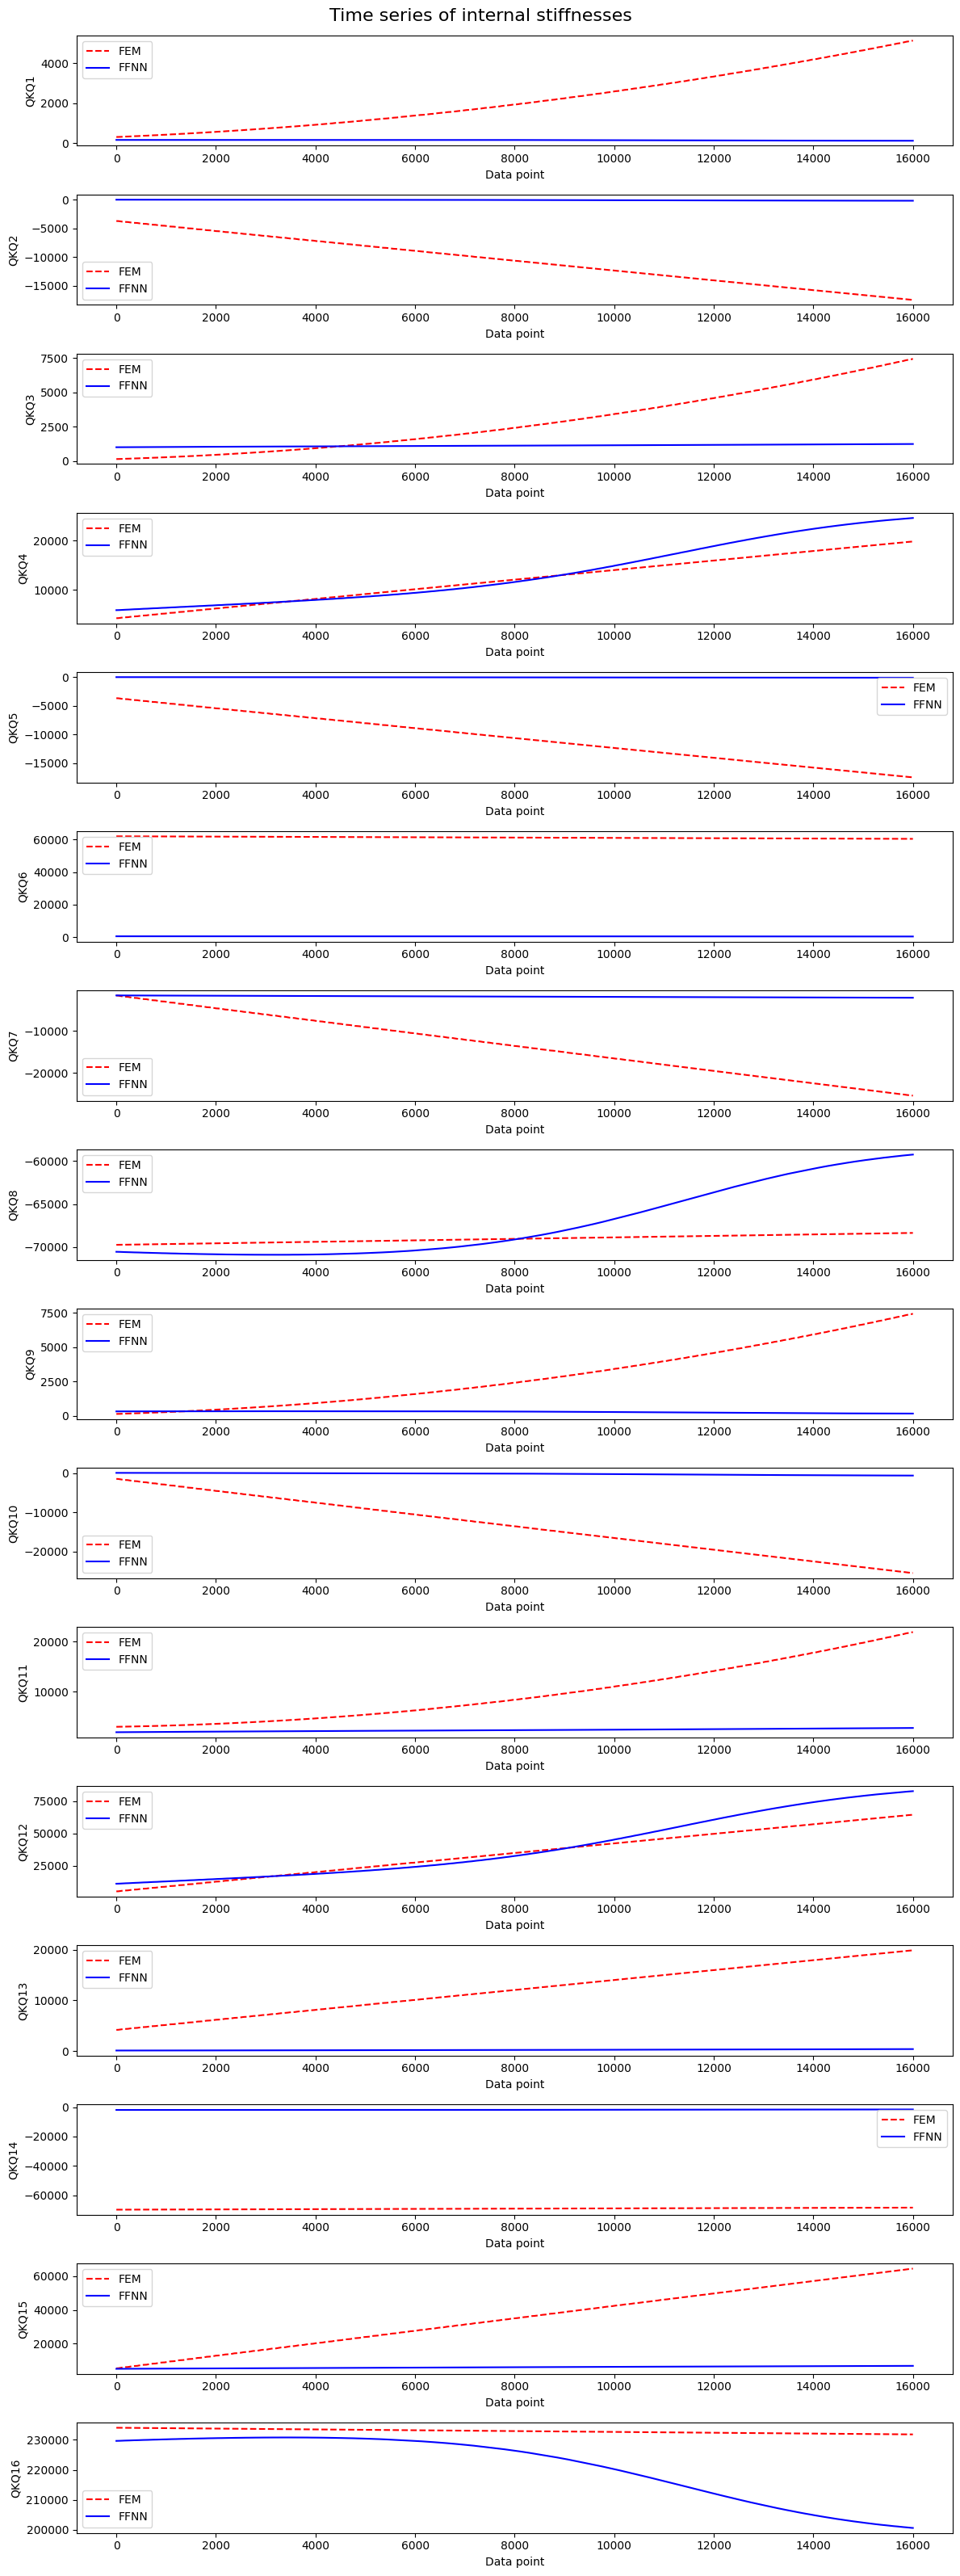

In [18]:
p.plot_predictions(q_test, Qf_test, Qf_pred_test, QKQ_test, QKQ_pred_test)

## 7. Analytical implementation and derivation of an FFNN

Before applying the neural network in the beam simulation, we want to demonstrate, how the FFNN can be analytically implemented and derived. A general FFNN can be described by a chain of operations

$$
\boldsymbol{y}_k = \sigma(\boldsymbol{W}_k \boldsymbol{y}_{k-1} + \boldsymbol{b}_{k})
$$

for $k \in {1, ..., h}$ and with $h$ being the number of layers. The derivative of the FFNN follows from the chain rule and can be computed with the product

$$
\frac{\partial \boldsymbol{y}_k}{\partial \boldsymbol{y}_0} = \prod_{i=1}^k \frac{\partial \sigma(\boldsymbol{y}_{i-1})}{\partial \boldsymbol{y}_{i-1}} \odot \boldsymbol{W}_i,
$$

where the operator $\odot$ denotes the element-wise Hadamad product. The analytical FFNN and its derivative are implemented below for a network with arbitrary node number as well as *softplus* and *linear* activation in the hidden and output layers, respectively. The implementation is verified against the Tensorflow model, which computes the derivatives numerically using automatic differentiation.

In [19]:
def mlp_analytical(w, x):
    ''' Analytical implementaion of FFNN and its first derivative with respect to inputs '''    

    # Intialization
    dy = tf.repeat(tf.expand_dims(tf.eye(x.shape[1]), axis=0), x.shape[0], axis=0)
    one = tf.expand_dims(tf.repeat(tf.expand_dims(tf.ones(x.shape[1]), axis=0), x.shape[0], axis=0), axis=1)
    
    # Loop over layers
    n = int(len(w) / 2)
    for i in range(n):
        h = tf.tensordot(x, w[2 * i], axes=[[1], [0]]) + w[2 * i + 1]
        if i < n - 1:
            x = tf.math.softplus(h)
            df = tf.expand_dims(tf.math.sigmoid(h), axis=1)
        else:
            x = h
            df = one
        dy_i = df * tf.expand_dims(w[2 * i], axis=0)
        dy = tf.einsum('ijk,ijl->ikl',dy_i,dy)
    return x, dy

# Save the weights of the Tensorflow model as a list
w = model.get_weights()

# Evaluate the Tensorflow model to obtain function values and gradients
_q = tf.convert_to_tensor(q, dtype=tf.float32)
Qf_m = tf.convert_to_tensor(model(_q)[0], dtype=tf.float32)
QKQ_m = tf.convert_to_tensor(model(_q)[1], dtype=tf.float32)


# Evaluate the analytical implementation to obtain function values and gradients
Qf_ana, QKQ_ana = mlp_analytical(w, _q)
flatten = tf.keras.layers.Flatten()


# Compate the Tensorflow and analytical results
print(f'Max. difference of function values: {tf.math.reduce_max(Qf_ana - Qf_m).numpy()}')
print(f'Max. difference of derivatives: {tf.math.reduce_max(flatten(QKQ_ana) - QKQ_m).numpy()}')

Max. difference of function values: 0.0
Max. difference of derivatives: 0.078125
